# Run additional Langevin step

In [1]:
import sys
sys.path.append('../../')
from attacks import get_advdist, get_detector
from loader import get_dataloader

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from omegaconf import OmegaConf

In [2]:

mh_cfg = OmegaConf.load('../../results/CIFAR10/vit_hf_md/svhn_affineV0_mh/benchmark_0/cifar_vit_hf_md_svhn_affineV0_mh.yml')
lgv_cfg = OmegaConf.load('../../results/CIFAR10/vit_hf_md/svhn_affineV0_lgv/benchmark_0/cifar_vit_hf_md_svhn_affineV0_lgv.yml')

In [4]:
mh_cfg['advdist']['sampler']['n_step'] = 100
mh_cfg['advdist']['sampler']['stepsize'] = 0.01
# lgv_cfg['']

In [3]:
device = 'cuda:1'

In [67]:
lgv_cfg['advdist']['sampler']['n_step'] = 100
# lgv_cfg['']

In [94]:
lgv_cfg['advdist']['sampler']['noise_std'] = 0.01
lgv_cfg['advdist']['sampler']['stepsize'] = 0.1

In [93]:
lgv_cfg['advdist']['sampler']['mh'] = False

In [5]:
advdist = get_advdist(mh_cfg)
detector = get_detector(**mh_cfg, normalize=True, root='../../')
detector.to(device)

advdist.detector = detector

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using vit_eval aug with params {'size': 224}
Normalizing detector score...


In [6]:
d = lgv_cfg['data']['out_eval']
d['path'] = '../../datasets'

In [7]:
dl = get_dataloader(d, subset=range(0, 100))

Using No Augmentations
Using No Augmentations
Using downloaded and verified file: ../../datasets/test_32x32.mat


In [10]:
xx, _ = next(iter(dl))

In [8]:
z = torch.load(f'../../results/CIFAR10/vit_hf_md/svhn_affineV0_mh/benchmark_0/advsample_z_0.pkl')

In [39]:
z.shape

torch.Size([100, 5])

In [11]:
d_sample = advdist.sample(img=xx.to(device), z0=z.to(device))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


In [59]:
d_sample_2 = advdist.sample(img=xx.to(device), z0=z.to(device))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:07<00:00,  1.07it/s]


In [70]:
''' langevin stepsize: 0.1, noise: 0.01'''
d_sample_3 = advdist.sample(img=xx.to(device), z0=z.to(device))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


In [85]:
''' langevin stepsize: 0.1, noise: 0.0'''
d_sample_4 = advdist.sample(img=xx.to(device), z0=z.to(device))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


In [96]:
''' langevin stepsize: 0.1, noise: 0.01, mh=False'''
d_sample_5 = advdist.sample(img=xx.to(device), z0=z.to(device))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


In [43]:
d_sample.keys()

dict_keys(['x', 'l_x', 'l_dynamics', 'l_drift', 'l_diffusion', 'l_accept', 'l_E', 'x_0', 'min_x', 'min_E', 'min_img', 'last_img'])

In [45]:
d_sample['l_E'].shape

torch.Size([201, 100])

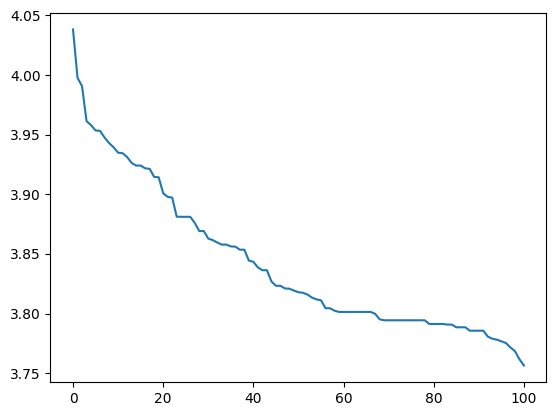

In [12]:
plt.plot(torch.cummin(d_sample['l_E'],dim=0).values.mean(dim=1))

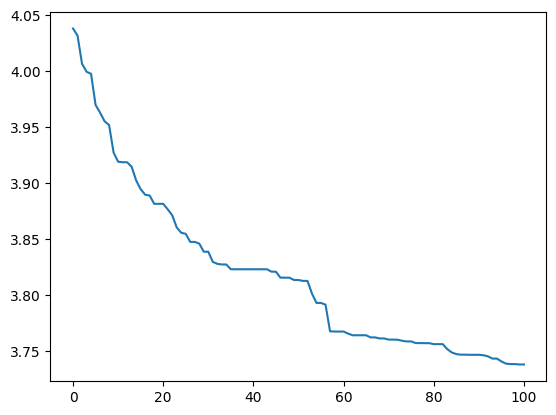

In [90]:
plt.plot(torch.cummin(d_sample_3['l_E'],dim=0).values.mean(dim=1))

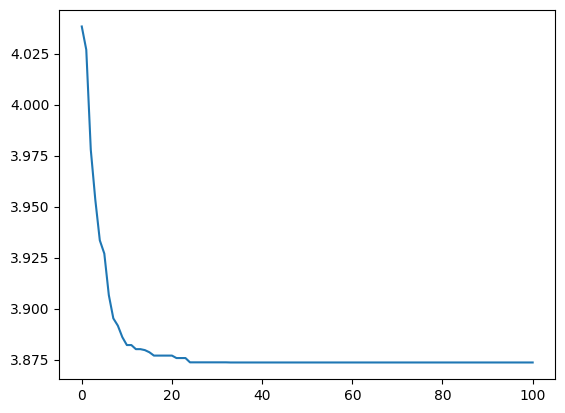

In [89]:
plt.plot(torch.cummin(d_sample_4['l_E'],dim=0).values.mean(dim=1))

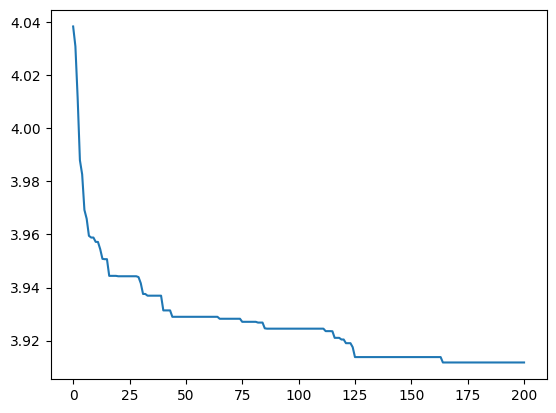

In [120]:
plt.plot(torch.cummin(d_sample_2['l_E'],dim=0).values.mean(dim=1))

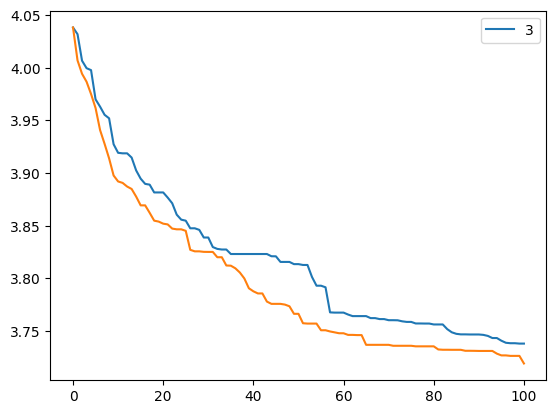

In [100]:
plt.plot(torch.cummin(d_sample_3['l_E'],dim=0).values.mean(dim=1), label='3')
plt.plot(torch.cummin(d_sample_5['l_E'],dim=0).values.mean(dim=1))
plt.legend()

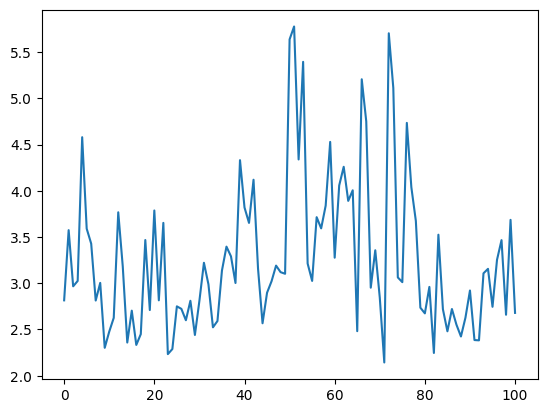

In [118]:
plt.plot(d_sample_5['l_E'][:,10])